# Decoding Board from Data

In [7]:
#necessary imports
import pandas
import numpy as np
import os
import tensorflow.keras as keras
from keras.models import Model
from keras.layers import Dense, Input
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex = True)
import math

import matplotlib.pyplot as plt
%matplotlib inline

%run Drivers.ipynb

EMPTY = 1;
COLOR = 0;

BLACK = -1;
WHITE = 1;

WIDTH = 9;

# Data Categorization and Assignment

In [8]:
Boards = []
Moves = []
def Main():
    path = "./go9"
    for entry in os.scandir(path): #I changed my mind i love python
        Go = True
        Board = createEmptyBoard() # 0 - 80 = [color, empty], 81 = [turn, turn]
        with open(entry) as f:
            if Go:
                for line in f:
                    if line[0] == ';': # this is the line with all the moves.
                        Go = False
                        copy = ""
                        for c in line:
                            if c != "[" and c != "]" and c != ")":
                                copy += c
                        arr = copy[1:].split(';')
                        for a in arr:
                            move = Decode_Move(a[1:])
                            if Decode_Move(a[1:]) == -1:
                                print(entry)
                                return
                            else:
                                color = 1
                                if(a[0] == 'B'):
                                    color = -1
                                Boards.append(Board)
                                Moves.append(move)
                                if(move != 81):
                                    Board = Move(Board, move, color)[1]
Main()
Boards = np.array(Boards)
Moves = np.array(Moves)

In [9]:
print(Boards.shape)

(414124, 82, 2)


In [10]:
# Example Position:
printBoard(Boards[25])

#  A B C D E F G H I
1  . . . . . . . . .
2  . . . . @ . . . .
3  . . O . @ O O . .
4  . . . O O @ . @ .
5  . . @ @ @ @ @ O .
6  . . . @ O O O O .
7  . . @ O O . . . .
8  . . . @ @ . . . .
9  . . . . . . . . .



In [11]:
X = Boards
Y = keras.utils.to_categorical(Moves, 82)

training_samples = int(0.9 * X.shape[0])
X_train, X_test = X[:training_samples], X[training_samples:] # Inputs
Y_train, Y_test = Y[:training_samples], Y[training_samples:] # Outputs

print(X.shape)
print(Y.shape)

(414124, 82, 2)
(414124, 82)


# Building the Model

In [12]:
input_shape = (82, 2)

model = keras.models.Sequential()
model.add(keras.layers.Dense(2, input_shape = input_shape))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(82, activation = 'relu'))
model.add(keras.layers.Dense(82, activation = 'relu'))
model.add(keras.layers.Dense(82, activation = 'relu'))
model.add(keras.layers.Dense(82, activation = 'relu'))
model.add(keras.layers.Dropout(.1))
model.add(keras.layers.Dense(82, activation = 'relu'))

model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer = keras.optimizers.Adam(), metrics = [keras.metrics.CategoricalAccuracy()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 82, 2)             6         
_________________________________________________________________
flatten_1 (Flatten)          (None, 164)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 82)                13530     
_________________________________________________________________
dense_8 (Dense)              (None, 82)                6806      
_________________________________________________________________
dense_9 (Dense)              (None, 82)                6806      
_________________________________________________________________
dense_10 (Dense)             (None, 82)                6806      
_________________________________________________________________
dropout_1 (Dropout)          (None, 82)               

# Training

In [13]:
# Load Weights
#model.load_weights('mini_weights.h5')

In [14]:
#Train the model
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
history = model.fit(X_train, Y_train, batch_size = 32, epochs = 128, workers = 10, verbose = 1, validation_data = (X_test, Y_test))

(372711, 82, 2)
(41413, 82, 2)
(372711, 82)
(41413, 82)
Epoch 1/128
11648/11648 [==============================] - 45s 4ms/step - loss: 7.7956 - categorical_accuracy: 0.0206 - val_loss: 7.2905 - val_categorical_accuracy: 0.0277
Epoch 2/128
 5262/11648 [============>.................] - ETA: 22s - loss: 7.3255 - categorical_accuracy: 0.0252

KeyboardInterrupt: 

In [66]:
# Save Weights
model.save_weights('mini_weights.h5')

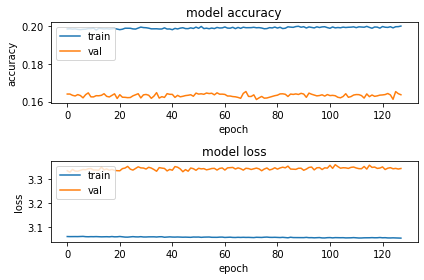

In [67]:
plt.figure(1)

plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss') 

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()